# Switchbacks identification

<div class="alert alert-block alert-info">
<b>References:</b> <br/>
- Plazanet, Corinne Margote, 2001. Modeling Geometry for Linear Feature Generalization. 
</div>

Un point d'inflexion est un point où la courbe change de convexité.

Un virage est délimité par deux points d'inflexion. Le virage est constitué des points de la trace entre ses deux points limites. 

Les lacets sont des séries de virage, fusion des virages successifs. Ils sont paramétrés suivant un nombre minimal de virage et une distance maximale entre les sommets de deux virages consécutifs.

## Import de la librairie tracklib

In [1]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import os.path
import sys

#-------------------------------------------------------
# Import de tracklib
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)


## Chargement de la trace + interpolation spatiale

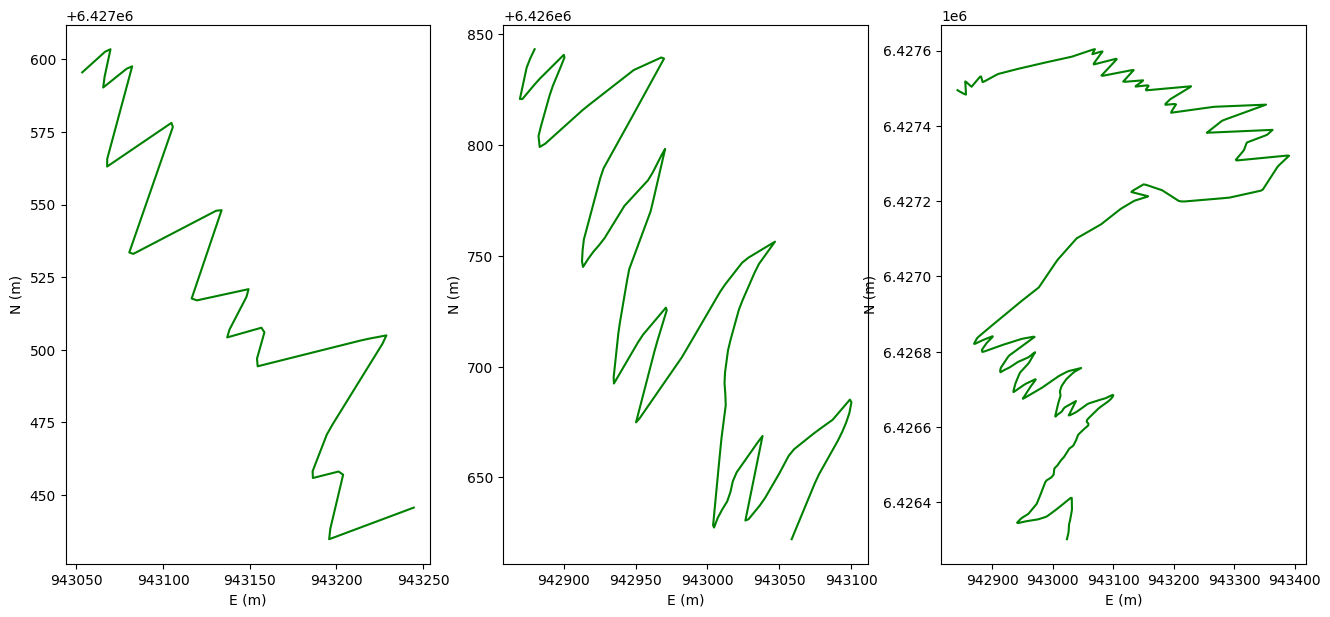

In [2]:
from tracklib.io.TrackReader import TrackReader
import tracklib.algo.Interpolation as interpolation
import tracklib.plot.Plot as Plot

csvpath = '../../../data/lacet/ecrins.csv'
tracks = TrackReader.readFromWkt(csvpath, 0, 1, 2, ",", 1, "ENUCoords", None, True)

trace = tracks["903959","%"][0]
trace.resample(5, interpolation.MODE_SPATIAL)

trace1 = trace.extract(468, 593)
trace2 = trace.extract(872, 1108)
trace3 = trace.extract(405, 1217)

plt.figure(figsize = (16,7))
plt.subplot(1, 3, 1)
trace1.plot(append = True, sym='g-', label='original extract track 1')
plt.subplot(1, 3, 2)
trace2.plot(append = True, sym='g-', label='original extract track 2')
plt.subplot(1, 3, 3)
trace3.plot(append = True, sym='g-', label='original extract track 3')

trace11 = trace1.copy()
trace22 = trace2.copy()
trace33 = trace3.copy()

## Lissage gaussien de la trace

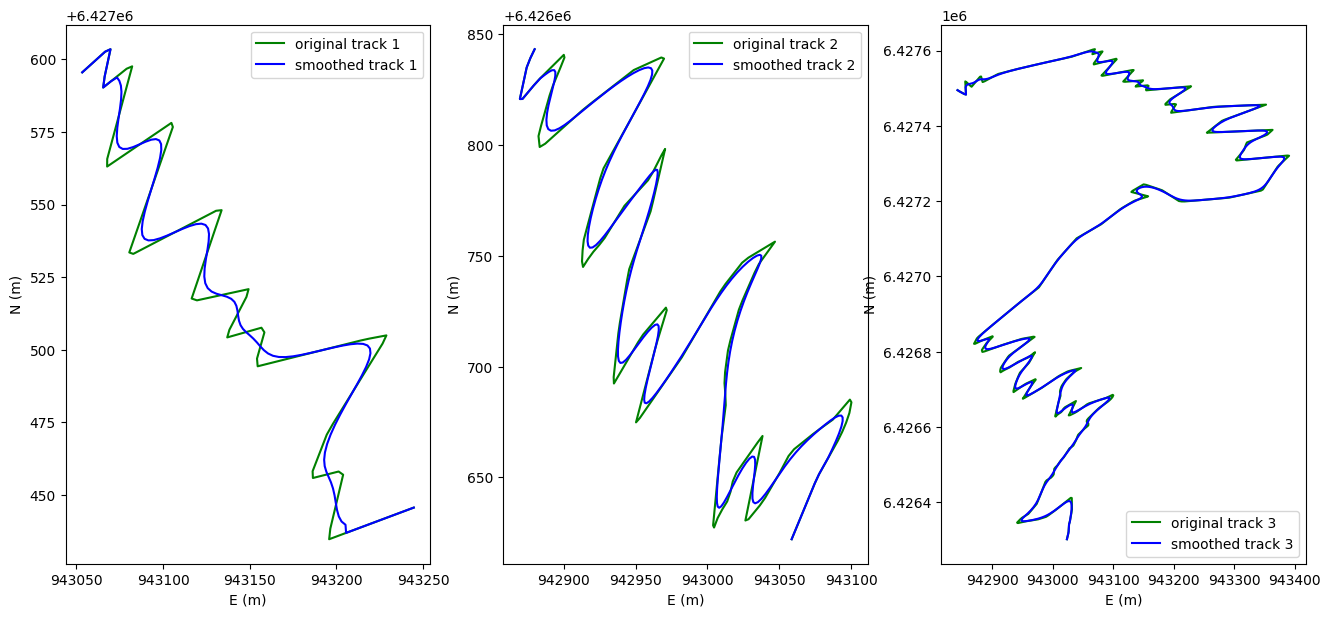

In [3]:
from tracklib.core.Kernel import GaussianKernel
from tracklib.core.Operator import Operator

kernel = GaussianKernel(3)

# On ré-initialise les traces pour jouer avec
trace1 = trace11.copy()
trace2 = trace22.copy()
trace3 = trace33.copy()

# Calcul
trace1.operate(Operator.FILTER, "x", kernel, "x_filtered")
trace1.operate(Operator.FILTER, "y", kernel, "y_filtered")
trace1.operate("x=x_filtered")
trace1.operate("y=y_filtered")

trace2.operate(Operator.FILTER, "x", kernel, "x_filtered")
trace2.operate(Operator.FILTER, "y", kernel, "y_filtered")
trace2.operate("x=x_filtered")
trace2.operate("y=y_filtered")

trace3.operate(Operator.FILTER, "x", kernel, "x_filtered")
trace3.operate(Operator.FILTER, "y", kernel, "y_filtered")
trace3.operate("x=x_filtered")
trace3.operate("y=y_filtered")

# Dessin
plt.figure(figsize = (16,7))
plt.subplot(1, 3, 1)
trace11.plot(append = True, sym='g-', label='original track 1')
trace1.plot(append = True, sym='b-', label='smoothed track 1')
plt.legend()
plt.subplot(1, 3, 2)
trace22.plot(append = True, sym='g-', label='original track 2')
trace2.plot(append = True, sym='b-', label='smoothed track 2')
plt.legend()
plt.subplot(1, 3, 3)
trace33.plot(append = True, sym='g-', label='original track 3')
trace3.plot(append = True, sym='b-', label='smoothed track 3')
plt.legend()



## Compute inflection points

<AxesSubplot: xlabel='E (m)', ylabel='N (m)'>

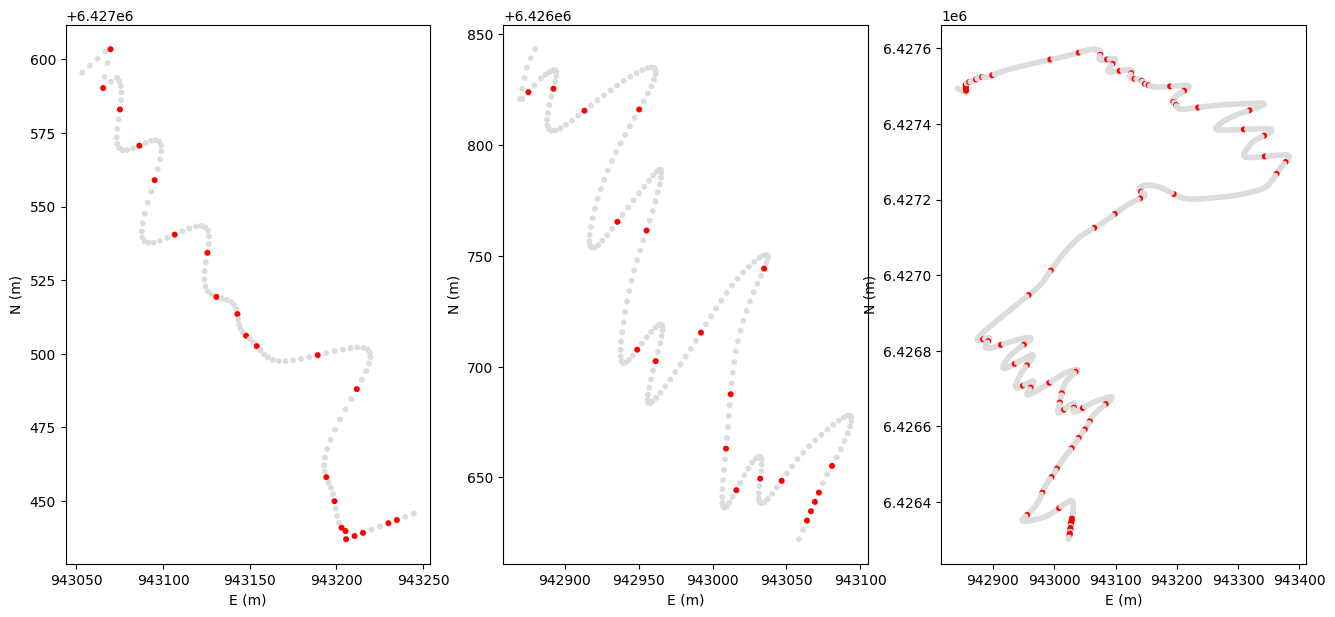

In [4]:
import tracklib.algo.Cinematics as Cinematics
import tracklib.core.Utils as utils

# Calcul
trace1.addAnalyticalFeature(Cinematics.inflection)
trace2.addAnalyticalFeature(Cinematics.inflection)
trace3.addAnalyticalFeature(Cinematics.inflection)

# Dessin
COLS = utils.getColorMap((220, 220, 220), (255, 0, 0))
plt.figure(figsize = (16,7))
plt.subplot(1, 3, 1)
trace1.plot(type='POINT', af_name='inflection', append = True, 
            cmap = COLS, pointsize=10)
plt.subplot(1, 3, 2)
trace2.plot(type='POINT', af_name='inflection', append = True, 
            cmap = COLS, pointsize=10)
plt.subplot(1, 3, 3)
trace3.plot(type='POINT', af_name='inflection', append = True, 
            cmap = COLS, pointsize=10)

## Détection des sommets

<AxesSubplot: xlabel='E (m)', ylabel='N (m)'>

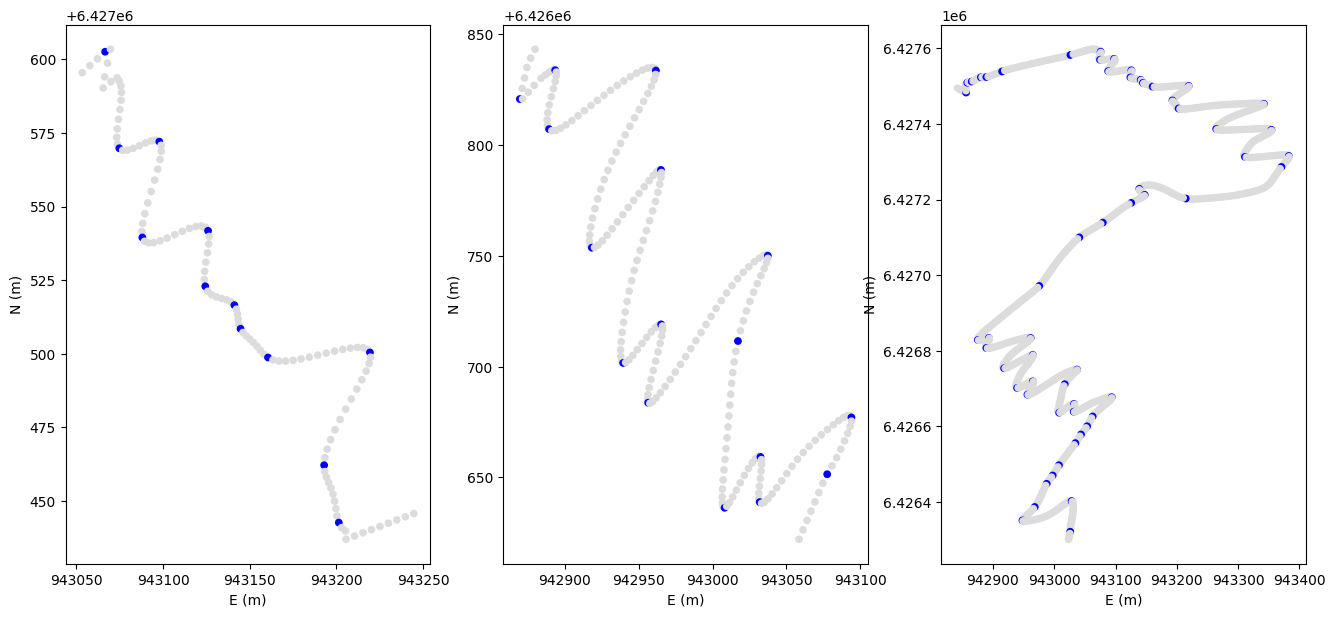

In [5]:
# Calcul
trace1.addAnalyticalFeature(Cinematics.vertex)
trace2.addAnalyticalFeature(Cinematics.vertex)
trace3.addAnalyticalFeature(Cinematics.vertex)

# Dessin
COLS = utils.getColorMap((220, 220, 220), (0, 0, 255))
plt.figure(figsize = (16,7))
plt.subplot(1, 3, 1)
trace1.plot(type='POINT', af_name='vertex', append = True, cmap = COLS, pointsize=20)
plt.subplot(1, 3, 2)
trace2.plot(type='POINT', af_name='vertex', append = True, cmap = COLS, pointsize=20)
plt.subplot(1, 3, 3)
trace3.plot(type='POINT', af_name='vertex', append = True, cmap = COLS, pointsize=20)

## Construction des virages


<AxesSubplot: xlabel='E (m)', ylabel='N (m)'>

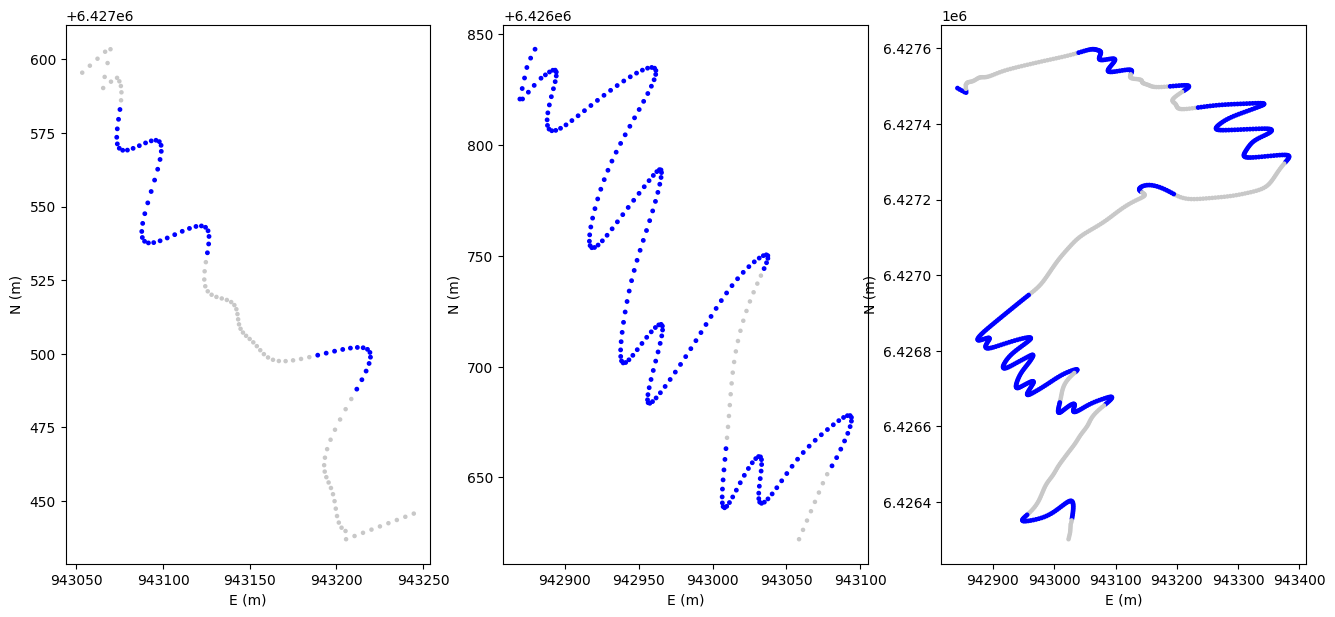

In [6]:
# Calcul
Cinematics.setBendAsAf(trace1)
Cinematics.setBendAsAf(trace2)
Cinematics.setBendAsAf(trace3)

# Dessin
COLS = utils.getColorMap((200, 200, 200), (0, 0, 255))
plt.figure(figsize = (16,7))
plt.subplot(1, 3, 1)
trace1.plot(type='POINT', af_name='bend', append = True, cmap = COLS)
plt.subplot(1, 3, 2)
trace2.plot(type='POINT', af_name='bend', append = True, cmap = COLS)
plt.subplot(1, 3, 3)
trace3.plot(type='POINT', af_name='bend', append = True, cmap = COLS)

## Construction des lacets

Il faut choisir 2 paramètres:
* distance maximum entre deux sommets pour qu'ils appartiennent a une même suite
* nombre de virages minimum pour constituer une série de virages


<AxesSubplot: xlabel='E (m)', ylabel='N (m)'>

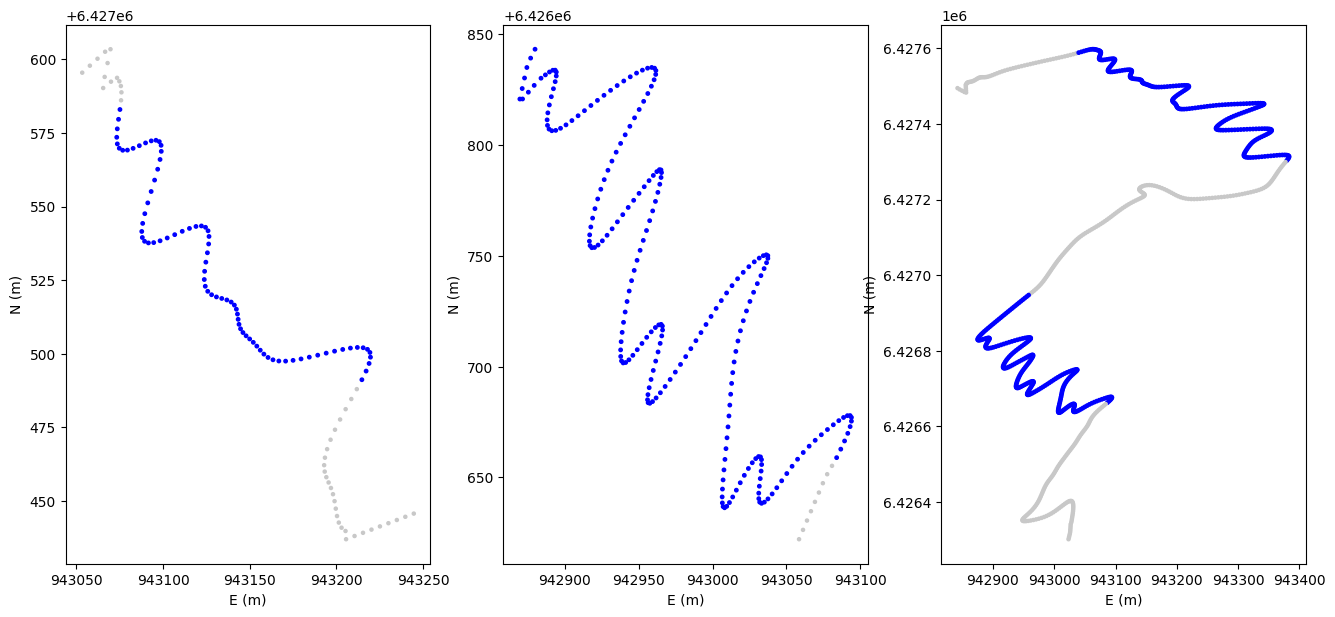

In [7]:
# Calcul
Cinematics.setSwitchbacksAsAf(trace1, 3, 150)
Cinematics.setSwitchbacksAsAf(trace2, 3, 150)
Cinematics.setSwitchbacksAsAf(trace3, 5, 150)

# Dessin
COLS = utils.getColorMap((200, 200, 200), (0, 0, 255))
plt.figure(figsize = (16,7))
plt.subplot(1, 3, 1)
trace1.plot(type='POINT', af_name='switchbacks', append = True, cmap = COLS)
plt.subplot(1, 3, 2)
trace2.plot(type='POINT', af_name='switchbacks', append = True, cmap = COLS)
plt.subplot(1, 3, 3)
trace3.plot(type='POINT', af_name='switchbacks', append = True, cmap = COLS)